In [ ]:
%%capture
!git clone https://github.com/naitik-2006/ml4sc

# Import Stuff

In [ ]:
import os
import time
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm  # for progress bars
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from torch.optim.lr_scheduler import OneCycleLR

# Variables

In [ ]:
BATCH_SIZE = 32
train_dir = "/content/ml4sc/dataset/train"
test_dir = "/content/ml4sc/dataset/val"

# Custom Dataset

In [ ]:
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with subfolders per class (e.g., ./train/class_name/)
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.samples = []  # list of tuples (file_path, label)
        self.transform = transform

        # List subdirectories and assign integer labels
        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_folder):
                if fname.endswith('.npy'):
                    file_path = os.path.join(class_folder, fname)
                    self.samples.append((file_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load .npy image; assume shape is H x W x C (if not, adjust accordingly)
        image = np.load(file_path)

        if image.ndim == 3 and image.shape[-1] in [1, 3]:
            image = np.transpose(image, (2, 0, 1))  # Convert to C x H x W

        if image.shape[0] == 1:  # If image is (1, H, W), expand to (3, H, W)
            image = np.repeat(image, 3, axis=0)  # Repeat across the 3 channels


        image = torch.tensor(image, dtype=torch.float)

        # Normalize if values are above 1 (i.e. in [0,255])
        image = image / 255.0 if image.max() > 1 else image

        if self.transform:
            image = self.transform(image)
        return image, label

# Utility Function

In [ ]:
# ---------------------------
# Utility: Visualize Sample Images from DataLoader
# ---------------------------

def show_sample_images(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_images]
    labels = labels[:num_images]
    # Convert tensor from C x H x W to H x W x C for plotting
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')
    plt.show()

# Model

In [ ]:
class DualOutputResNet(nn.Module):
    """
    DualOutputResNet produces two outputs:
      1. A classification output for dark matter morphology.
      2. A deflection map output (shape: [N, 1, 150, 150]) that reflects
         the gravitational lensing distortion, generated purely with conv2d layers.

    The deflection branch converts the ResNet features to an intermediate tensor of shape
    (N, 2500, 3, 3) and then rearranges it using PixelShuffle with an upscale factor of 50
    (since 2500 = 50^2) to obtain a (N, 1, 150, 150) output.
    """
    def __init__(self, num_classes=3):
        super(DualOutputResNet, self).__init__()

        # Load a pretrained ResNet50 model and remove its final fully connected layers.
        resnet = models.resnet34(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.feature_dim = 512

        # This branch applies a few conv layers, global pooling, and final 1x1 convolutions
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Output shape: (N, 512, 1, 1)
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, 32),  # Reduce channels to 64
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),  # Reduce channels to 64
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)  # Final conv: produces (N, num_classes, 1, 1)
        )

        # This branch uses convolutional layers to generate an intermediate tensor of shape (N, 2500, 3, 3)
        # and then rearranges it using PixelShuffle to get a (N, 1, 150, 150) deflection map.
        self.deflection_branch = nn.Sequential(
            nn.Conv2d(self.feature_dim, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 625, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((6, 6))  # Output: (N, 2500, 3, 3)
        )

        # PixelShuffle: upscale_factor = 50 transforms (N, 2500, 3, 3) to (N, 2500/(50^2), 3*50, 3*50)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=25)
        self.deflection_activation = nn.Sigmoid()  # Normalize output (optional)

    def forward(self, x):
        features = self.resnet(x)  # Output shape: (N, 2048, 5, 5)

        class_out = self.classifier(features)  # Shape: (N, num_classes, 1, 1)
        class_out = class_out.view(class_out.size(0), -1)  # Final shape: (N, num_classes)

        # Deflection map generation:
        deflection_intermediate = self.deflection_branch(features)  # Shape: (N, 2500, 3, 3)
        deflection_map = self.pixel_shuffle(deflection_intermediate)  # Shape: (N, 1, 150, 150)
        deflection_map = self.deflection_activation(deflection_map)

        return class_out, deflection_map



In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            probs = F.softmax(outputs, dim=1)  # Apply softmax for probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = np.argmax(y_scores, axis=1)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Classification Report
    print('Classification Report:\n', classification_report(y_true, y_pred))

    # Compute ROC Curve and AUC Score
    plt.figure(figsize=(8, 6))
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return accuracy

In [ ]:
from copy import deepcopy

In [ ]:
def deltamat(shape):
    kk = np.zeros((shape, shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = (((i+1)**2) + ((j+1)**2))**0.5
    return torch.tensor(kk, dtype=torch.float32)

positiontensor = deltamat(150)  # Shape: (150, 150)
positiontensor = positiontensor.unsqueeze(dim=0)  # Now shape: (1, 150, 150)
positiontensor = positiontensor.to("cuda")

In [ ]:
# Assume no_substructure class index is 0.
NO_SUBSTRUCTURE_LABEL = 0

def train_model(model, train_loader, test_loader, num_epochs=15, device='cuda', save_path='./saved_models', lambda_rec=0.00001):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # or use AdamW/RAdam as needed

    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=5e-3,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100
    )

    os.makedirs(save_path, exist_ok=True)

    loss_history = []
    epoch_times = []

    print("Starting training...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        epoch_start_time = time.time()
        images_count = 0

        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in train_bar:
            images = images.to(device)           # Observed (lensed) image, shape: (N, 3, 150, 150)
            labels = labels.to(device)

            # ---- Forward Pass on Observed Image ----
            optimizer.zero_grad()
            class_out_obs, defl_map_obs = model(images)
            loss_class_obs = criterion(class_out_obs, labels)

            # Compute training accuracy for observed image
            _, preds_obs = torch.max(class_out_obs, 1)
            correct_train += (preds_obs == labels).sum().item()
            total_train += labels.size(0)
            running_loss += loss_class_obs.item() * images.size(0)
            images_count += images.size(0)

            # ---- Reconstruct Original (Unlensed) Image ----
            # The deflection map is (N, 1, 150, 150); replicate to 3 channels for subtraction.
            deflection_with_position = defl_map_obs.detach().clone()  # Shape: (N, 1, 150, 150)
            defl_map_rep = deflection_with_position.repeat(1, 3, 1, 1)
            reconstructed = images - defl_map_rep  # This is our estimated original image.

            # ---- Forward Pass on Reconstructed Image ----
            # Desired classification label: no_substructure (assumed index 0)
            # Desired deflection map: zeros
            class_out_rec, defl_map_rec = model(reconstructed)
            loss_defl = defl_map_rec.sum()

            # Total reconstruction loss with a small weight
            loss_reconstruction = lambda_rec * loss_defl + loss_class_obs
            loss_total = loss_reconstruction
            loss_total.backward()
            optimizer.step()

            scheduler.step()

            # Update progress bar
            train_bar.set_postfix({
                "Loss": f"{loss_total.item():.4f}",
                "Acc": f"{(correct_train / total_train) * 100:.2f}%",
                "LR": f"{scheduler.get_last_lr()[0]:.6f}"
            })

        epoch_loss = running_loss / images_count
        loss_history.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        model_save_path = os.path.join(save_path, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Train Acc: {(correct_train / total_train) * 100:.2f}%, Time: {epoch_time:.2f}s")
        print(f"Model saved: {model_save_path}")

        evaluate_model(model , test_loader, device)

        # Evaluate on test data (function evaluate_model not shown here)
        # evaluate_model(model, test_loader, device)

    # Plot training loss vs. epochs
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs. Epochs")
    plt.grid(True)
    plt.show()

    return loss_history, epoch_times


# Main Code

In [ ]:
train_dataset = NpyDataset(train_dir)
test_dataset = NpyDataset(test_dir)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = list(train_dataset.class_to_idx.keys())

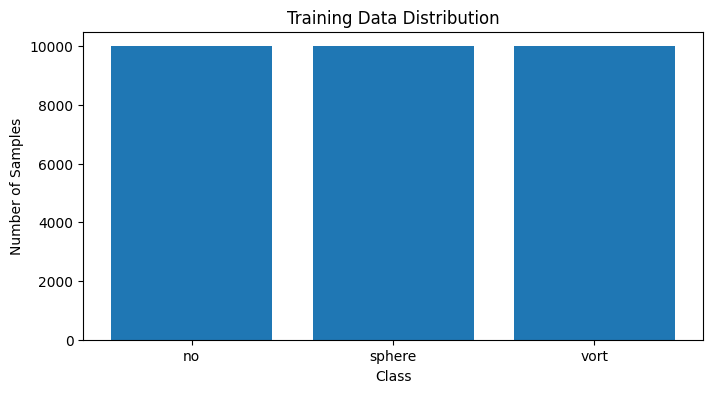

In [ ]:
# Plot distribution of classes in the training set

class_counts = {cls: 0 for cls in train_dataset.class_to_idx.keys()}
for _, label in train_dataset:
    for cls, idx in train_dataset.class_to_idx.items():
        if label == idx:
            class_counts[cls] += 1

plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Training Data Distribution")
plt.show()

Showing sample images from training data:


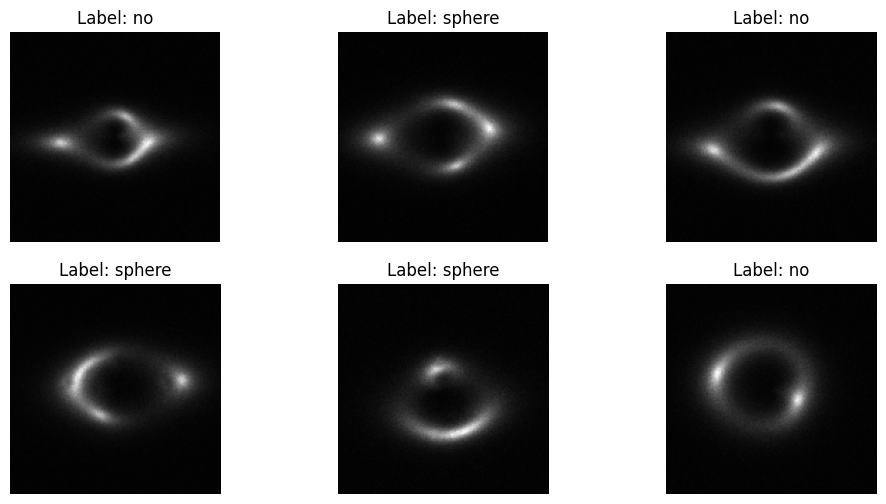

Showing sample images from test data:


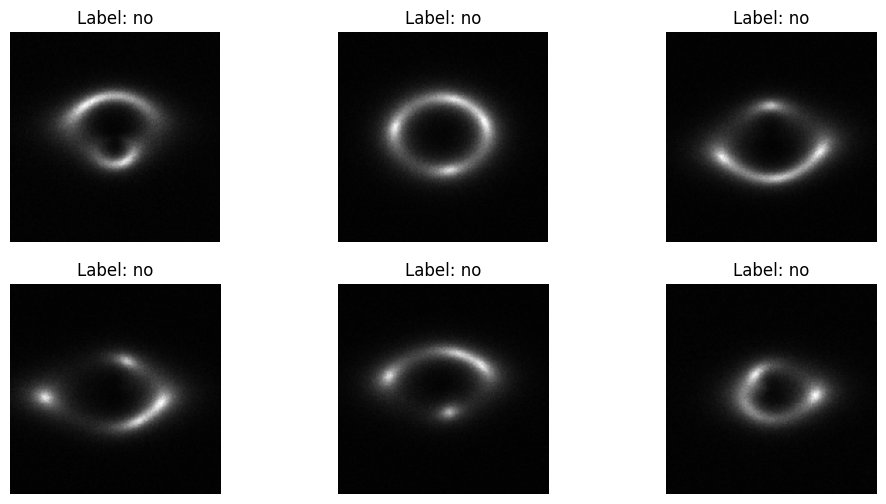

In [ ]:
# Visualize sample images from train and test to ensure DataLoader works
print("Showing sample images from training data:")
show_sample_images(train_loader, class_names, num_images=6)
print("Showing sample images from test data:")
show_sample_images(test_loader, class_names, num_images=6)

In [ ]:
# Get the pretra|ined model
model = DualOutputResNet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...


Epoch [1/15]:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 150, 150])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [1/15]: 100%|█████████▉| 937/938 [03:10<00:00,  5.12it/s, Loss=1295999.8750, Acc=33.12%, LR=0.003798]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1, 150, 150])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15] Loss: 1.1003, Train Acc: 33.12%, Time: 191.07s
Model saved: ./saved_models/model_epoch_1.pth
Accuracy: 0.3333
Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2500
           1       0.00      0.00      0.00      2500
           2       0.00      0.00      0.00      2500

    accuracy                           0.33      7500
   macro avg       0.11      0.33      0.17      7500
weighted avg       0.11      0.33      0.17      7500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


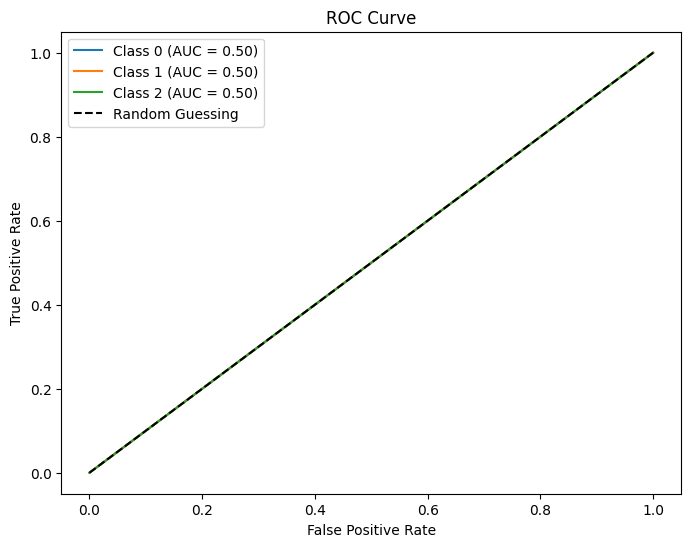

Epoch [2/15]:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 150, 150])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch [2/15]:  51%|█████     | 480/938 [01:34<01:29,  5.13it/s, Loss=1295999.8750, Acc=33.45%, LR=0.005000]

In [ ]:
# Train the model with freezing + cosine annealing
loss_history, epoch_times = train_model(model, train_loader, test_loader, num_epochs=15,  device='cuda')